I've added a new column to the known planets and TOI+ list dataframes, 'mass_flag', which is 1 if a planet has a known mass and 0 if its mass is taken from the Chen & Kipping M-R relationship. By default, all TOIs get a 0 for their mass_flag, so this doesn't take into account the few TOIs that happen to also be known planets with mass measurements (e.g. TOI-1731.01 is HAT-P-9 b). This should be a small effect (applies to ~10s of planets out of the 100s of planets in TKS' selected_TOIs target pool), if we run into it at all here, but I need to double check if any of the TOIs in our target list are actually known planets.

This notebook makes plots of the parameter space for different mixtures of known and TOI targets.

In [1]:
# Load necessary packages and tools

# System
import os
import sys
import glob

# Data/analysis
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100 # See all of the columns when DFs are displayed

# Util functions
from priority_tools import * # Implementation details and comments can be found in this file
from X_ranking import get_X_ranked_df

# Plotting (with fancy font/backend output)
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high quality figures

%load_ext autoreload
%autoreload 2

In [2]:
def get_newest_csv(folder_path):
    '''
    Get the filename of csv file in folder_path that is the most recent.
    
    Taken from: https://stackoverflow.com/questions/39327032/how-to-get-the-latest-file-in-a-folder-using-python
    '''
    folder_path += '*.csv'
    list_of_files = glob.glob(folder_path) # * means all if need specific format then *.csv
    return max(list_of_files, key=os.path.getctime)

def get_num_priority_targets(df, priority='X_priority', num_to_rank=3):
    '''
    Get the number of priority 1, 2, 3, ... etc. targets in the DataFrame df.
    '''
    return [len(df[df[priority] == i]) for i in range(1, num_to_rank+1)]

def report_num_priority_targets(df, priority='X_priority', num_to_rank=3):
    '''
    Print out a message about how many priority 1, 2, 3, ... etc. targets there are.
    '''
    num_list = get_num_priority_targets(df, priority=priority, num_to_rank=num_to_rank)
    tot_num_p = sum(num_list)
    sys.stdout.write("Of the {} targets with priorities, ".format(tot_num_p))
    for i in range(1,num_to_rank+1):
        sys.stdout.write('{} are Priority {}'.format(num_list[i-1], i))
        if i in range(1,num_to_rank):
            sys.stdout.write(', ')
        else:
            sys.stdout.write('.')
    print('')
    print('----------')
                         
toi_path = get_newest_csv('data/toi/')
tic_path = get_newest_csv('data/exofop/')
selected_TOIs_path = get_newest_csv('data/TKS/')

# Check to make sure these are the files that you want to use
print('TOI+ list file used: \t {}'.format(toi_path))
print('TIC ExoFOP file used: \t {}'.format(tic_path))
print('selected_TOIs file used: {}'.format(selected_TOIs_path))

TOI+ list file used: 	 data/toi/toi+-2020-07-21.csv
TIC ExoFOP file used: 	 data/exofop/exofop_search_2020-07-21.csv
selected_TOIs file used: data/TKS/selected_TOIs_2020-07-21.csv


In [3]:
# This call will take a few seconds to execute
num_to_rank = 5 # The number of targets to rank in each bin
X_df, __________ = get_X_ranked_df(toi_path, tic_path, 
                                   kp_file=r'data/known_planets/known_planets.csv',
                                   num_to_rank=num_to_rank, 
                                   include_qlp=True, 
                                   dec_cut=-30, 
                                   k_amp_cut=0) # Don't really need the second dataframe that's returned
print("The X_df dataframe has {} rows.".format(len(X_df)))
report_num_priority_targets(X_df, num_to_rank=num_to_rank)
p1_df = X_df[X_df['X_priority'] == 1.0]
num_p1_kp = len(p1_df[pd.isnull(p1_df['Source Pipeline'])])
num_p1_toi = len(p1_df) - num_p1_kp
print("Of the remaining priority 1 targets, {} are known planets and {} are from the TOI+ list.".format(num_p1_kp, num_p1_toi))

The X_df dataframe has 722 rows.
Of the 211 targets with priorities, 55 are Priority 1, 46 are Priority 2, 39 are Priority 3, 36 are Priority 4, 35 are Priority 5.
----------
Of the remaining priority 1 targets, 4 are known planets and 51 are from the TOI+ list.


In [4]:
X_df[X_df['Full TOI ID'] == 'GJ 436 b'] # Look at a specific row of the table
#X_df.loc[2,2,1].sort_values('TSM').sort_values('X_priority') # Look at a specific bin

,,,Source Pipeline,Full TOI ID,Planet Radius Value,Orbital Period Value,Effective Temperature Value,Effective Stellar Flux Value,Planet Equilibrium Temperature (K) Value,mass_flag,V mag,K_amp,TSM,t_HIRES,X,TSM_Vmag_priority,X_priority
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,
4,3,1,NaN,GJ 436 b,4.17,2.643883,3479.0,32.861256,NaN,1.0,NaN,16.936752,495.798003,NaN,NaN,2.0,NaN


In [5]:
# Define the bins
rad_bins = 10**(np.linspace(0,1,6)) 
rad_bins[-1] = 11.2 #want to include up to Jupiter radius 
fpl_bins = 10**(np.linspace(-1,4,6))
tef_bins = np.array([2500,3900,5200,6500])
bins = [rad_bins, fpl_bins, tef_bins]

# If you want to cut to the chase, skip down to cell that starts with "Now let's say..."
# ---------------------------------------------------------------------------------

# Plot all of the members of the known planets list and TOIs
**Plotting color key**:

    Green: Priority 1 target in its bin

    Yellow: Priority 2

    Orange: Priority 3

    Light pink: Priority 4

    Cyan: Priority 5

    Black: Unranked in its bin

    Magenta: A known planet with a mass measurement

    Red: A known planet with a featureful transmission spectrum

    Gray: A known planet with a featureless transmission spectrum

In [12]:
# Code in this cell adapted from Nicholas
for i in np.arange(1,6):
    bin_plotter(X_df.rename(columns={'X_priority':'priority'}),bins,i)

Let's check to see if there are any bins that have ranked TOIs, but no known planets with masses

In [11]:
# Bins that have at least 1 planet with a mass measurement already
bins_w_masses = X_df[X_df['mass_flag'] == 1.0].index.unique()

In [8]:
# Load the ranked list that was merged with selected TOIs
target_list_df = pd.read_csv('data/sc3_target_list_5ranked_mass_flag_2020-04-09.csv')

In [13]:
target_list_bins_df = target_list_df.copy()
target_list_bins_df = target_list_bins_df.set_index(['radius_bin', 'insol_bin', 'st_Teff_bin'])
target_list_bins = target_list_bins_df.index.unique()

In [14]:
target_bins_no_masses = []
for i in range(len(target_list_bins)):
    if target_list_bins[i] not in bins_w_masses:
        target_bins_no_masses.append(target_list_bins[i])

In [15]:
# These are the bins that we have ranked targets in and that don't have a mass measurement already!
target_bins_no_masses

[(1, 5, 3), (3, 5, 3)]

The ranked TOIs that survive the merging with selected_TOIs that correspond to these bins are:

(1,5,3): TOI 561.02 (Priority 1)
- Already being included in Lauren's TKS II paper
    
(3, 5, 3): TOI 1681.01 (Priority 3)

Let's take a look at TOI 1681.01

In [16]:
# A little info about TOI-1681.01
# Very short orbital period, boiling hot

# You can use this line to look up information about a TOI number, just change the TOI id below
target_list_df[target_list_df['Full TOI ID'] == 1681.01]

,radius_bin,insol_bin,st_Teff_bin,Source Pipeline,Full TOI ID,Planet Radius Value,Orbital Period Value,Effective Temperature Value,Effective Stellar Flux Value,Planet Equilibrium Temperature (K) Value,mass_flag,V mag,K_amp,TSM,t_HIRES,X,TSM_Vmag_priority,X_priority,toi,tic,cps,disp,vetting,ao_vet,hires_prv,apf_prv,vip_rank
59,3,5,3,spoc,1681.01,3.26185,1.537559,5672.5,1160.699357,1488.674282,0.0,10.97,5.910641,86.459725,849.496393,0.101778,3.0,3.0,1681.01,321041369,T001681,PC,passed,passed,NaN,NaN,NaN


# Let's plot all of the TOIs that are in our ranked list:
**Plotting color key**:

    Green: Priority 1 target in its bin

    Yellow: Priority 2

    Orange: Priority 3

    Light pink: Priority 4

    Cyan: Priority 5

    Black: Unranked in its bin

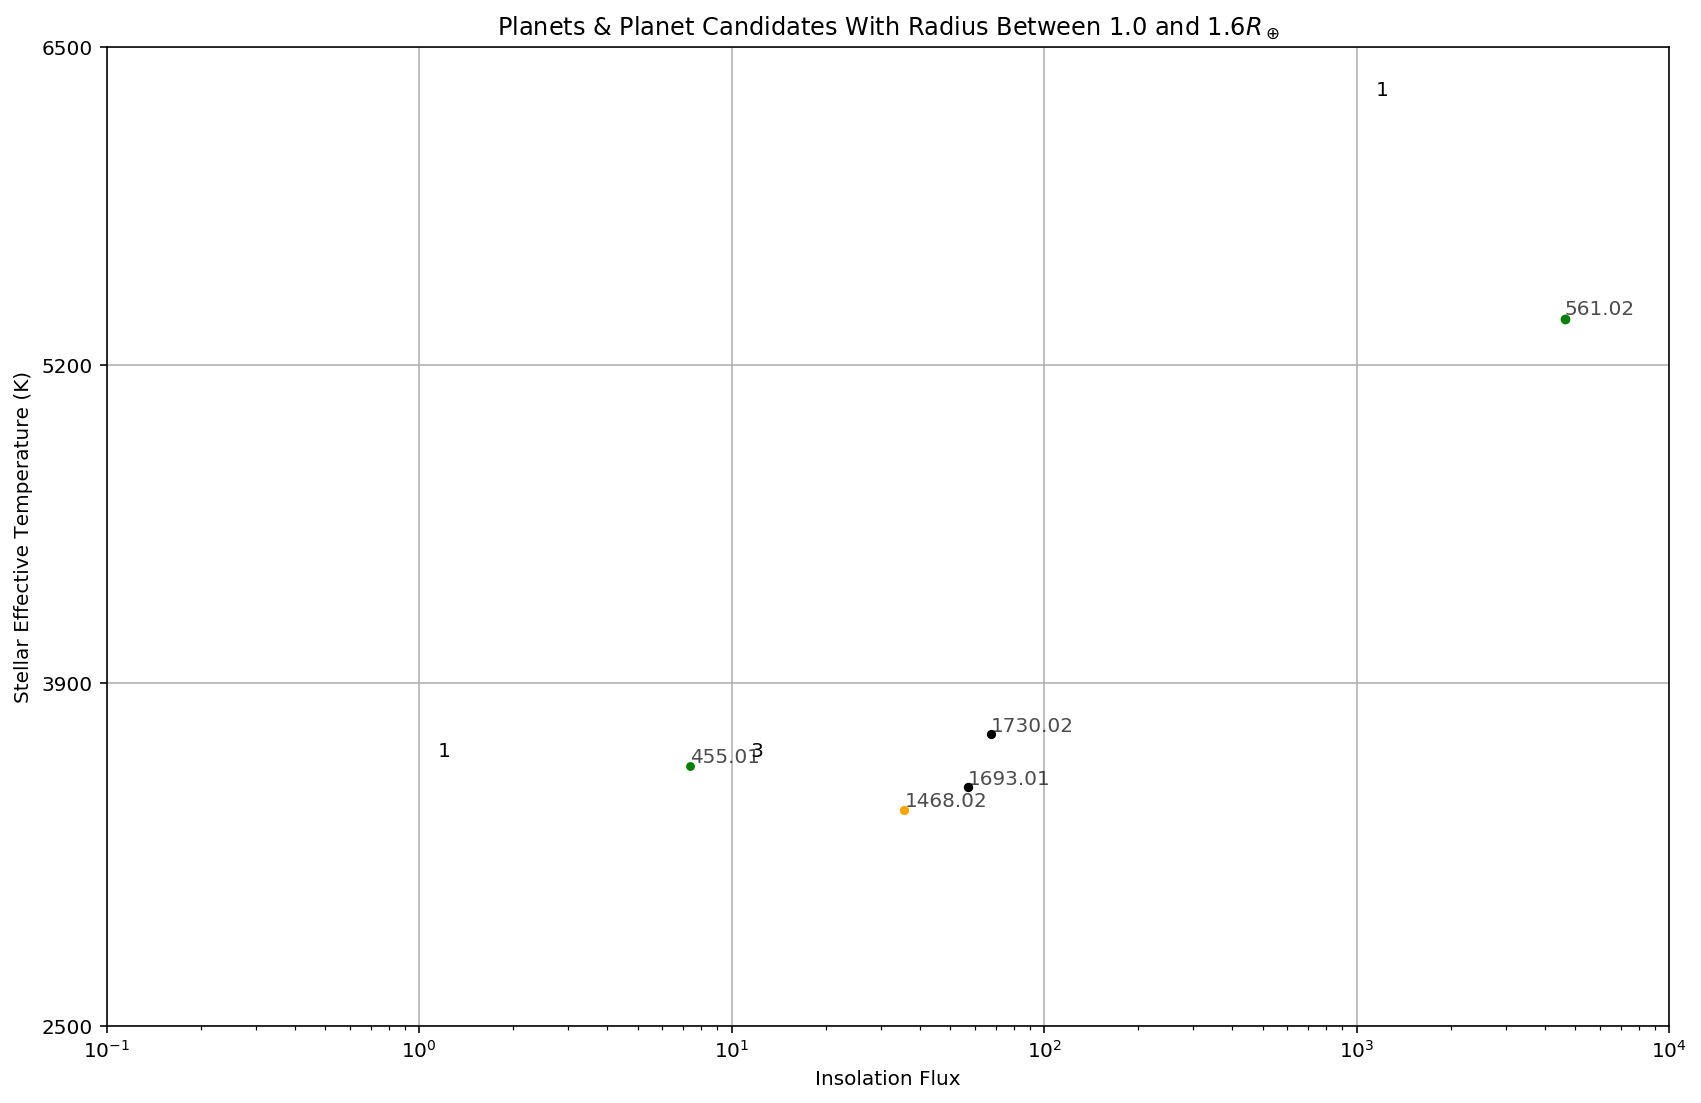

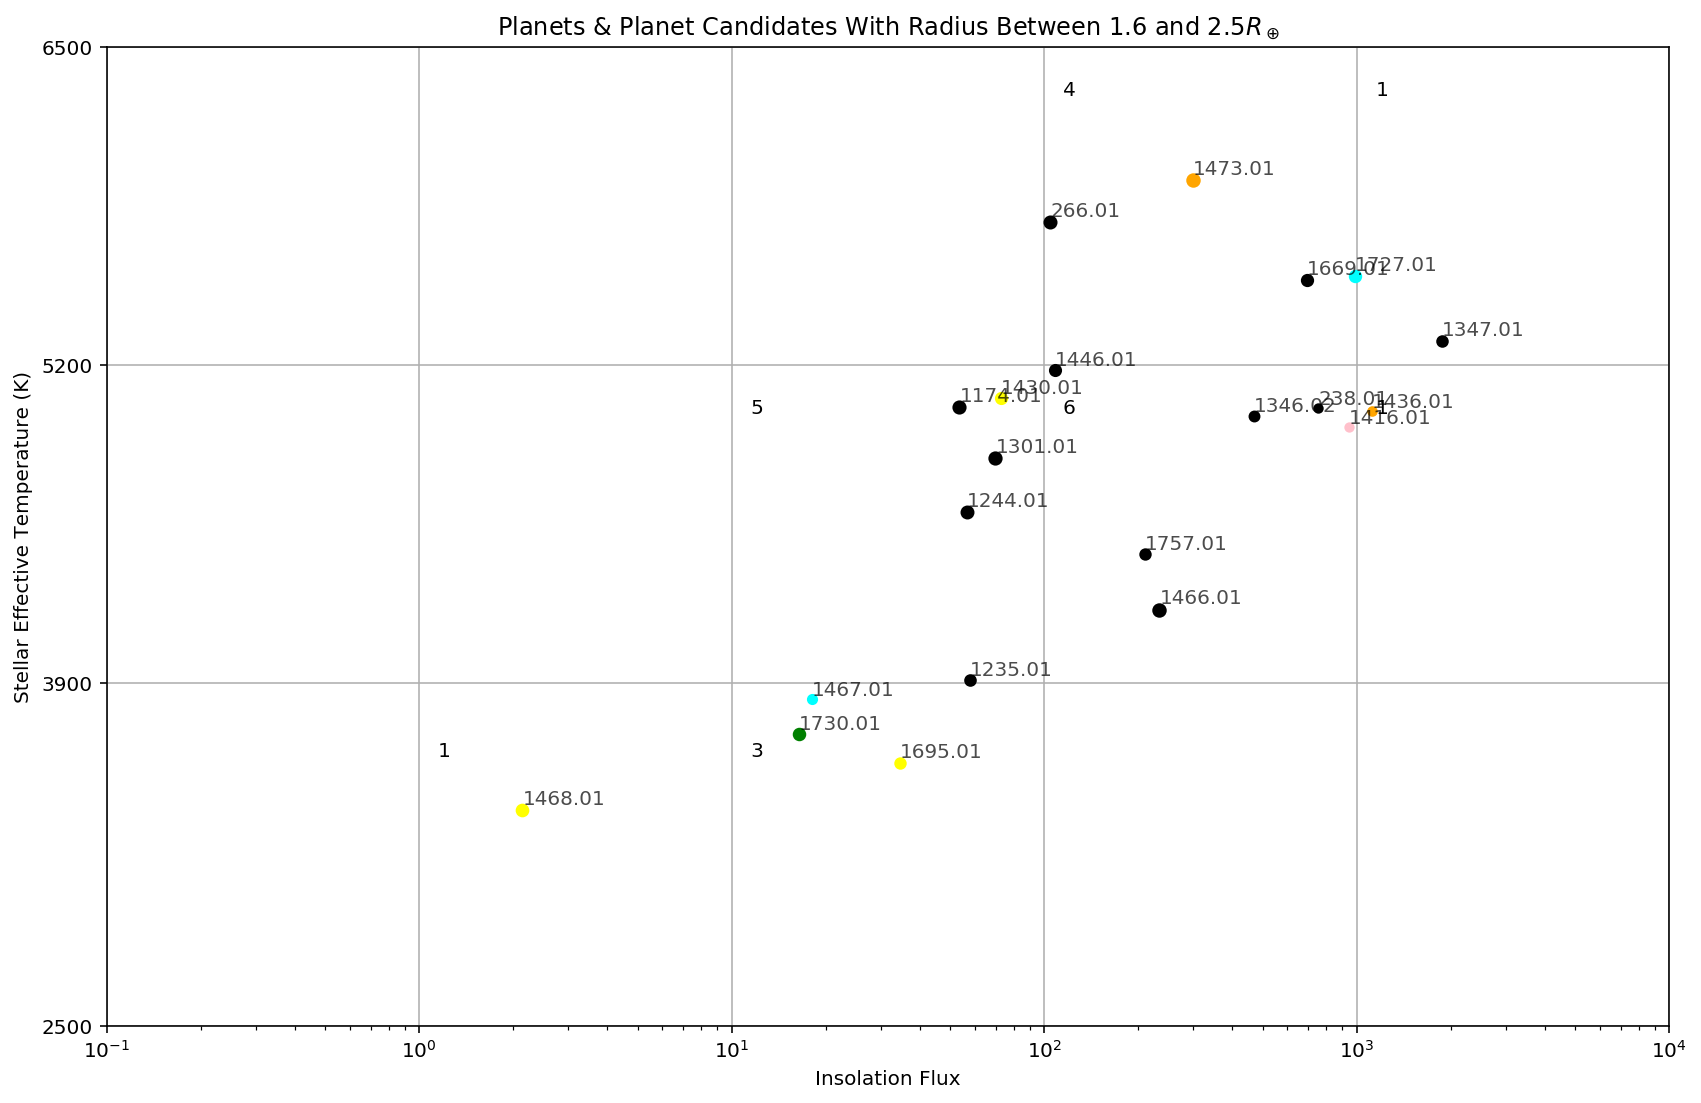

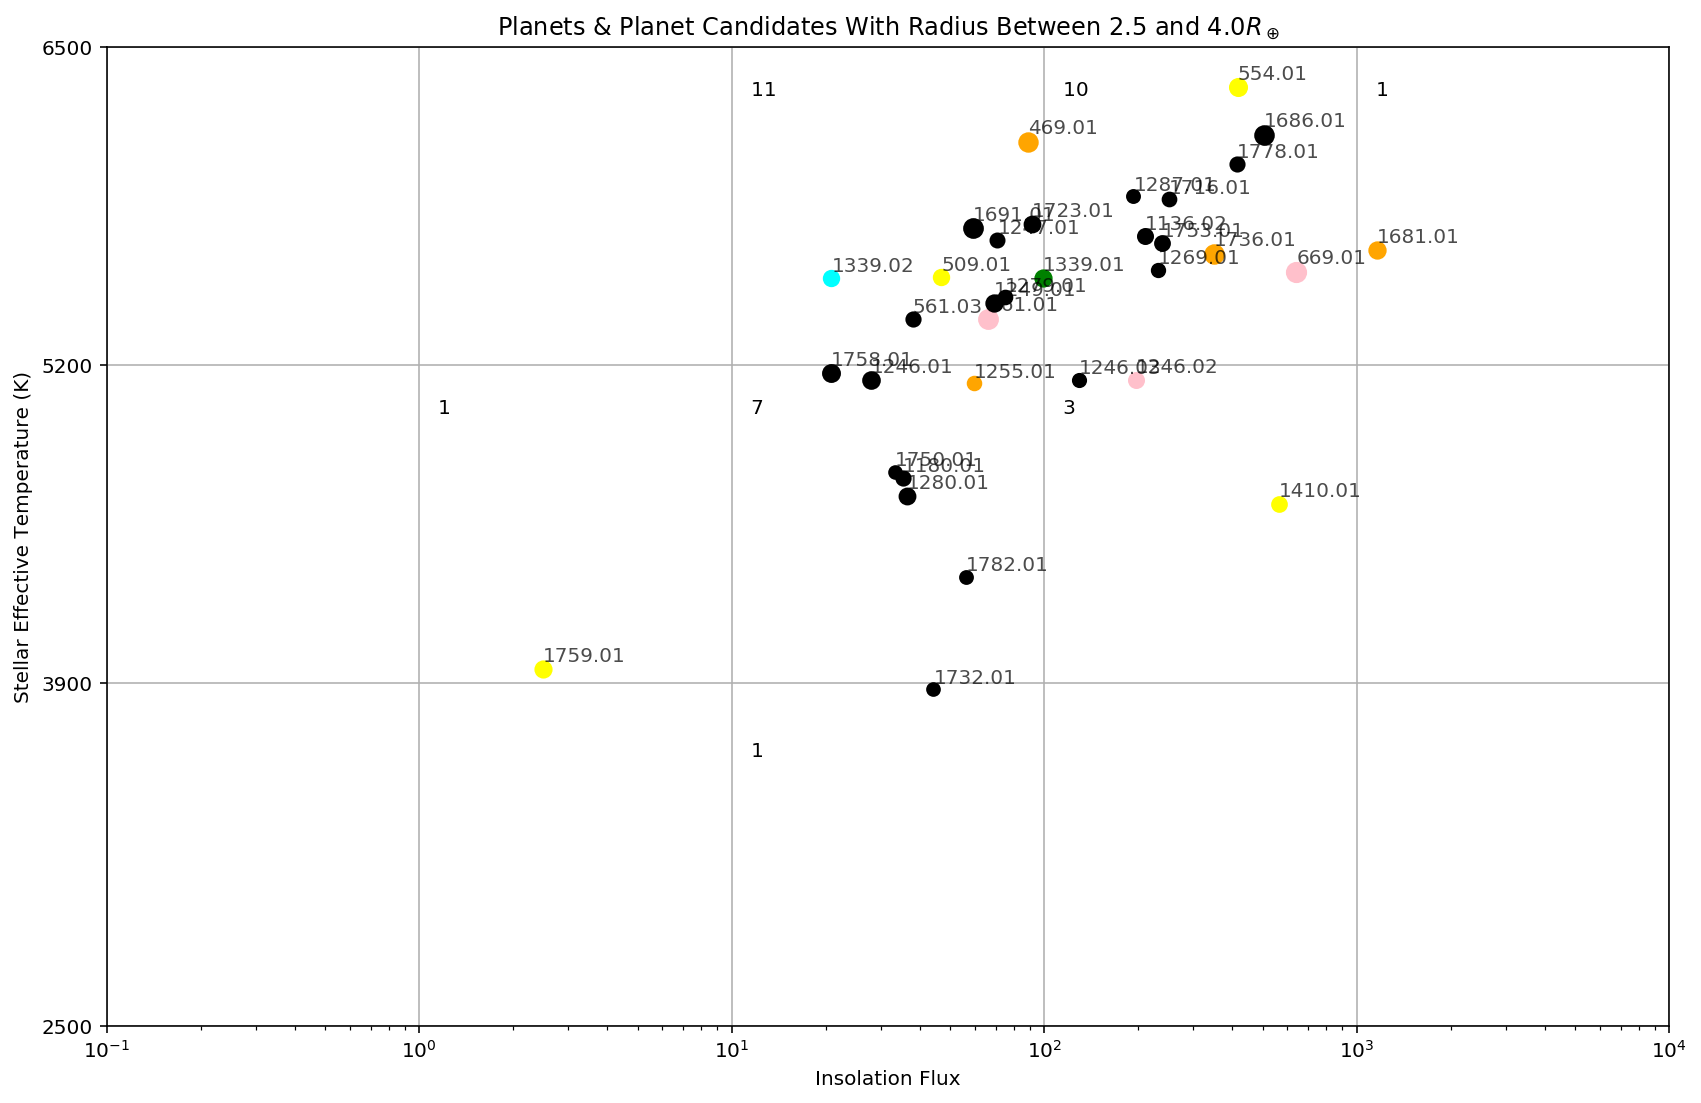

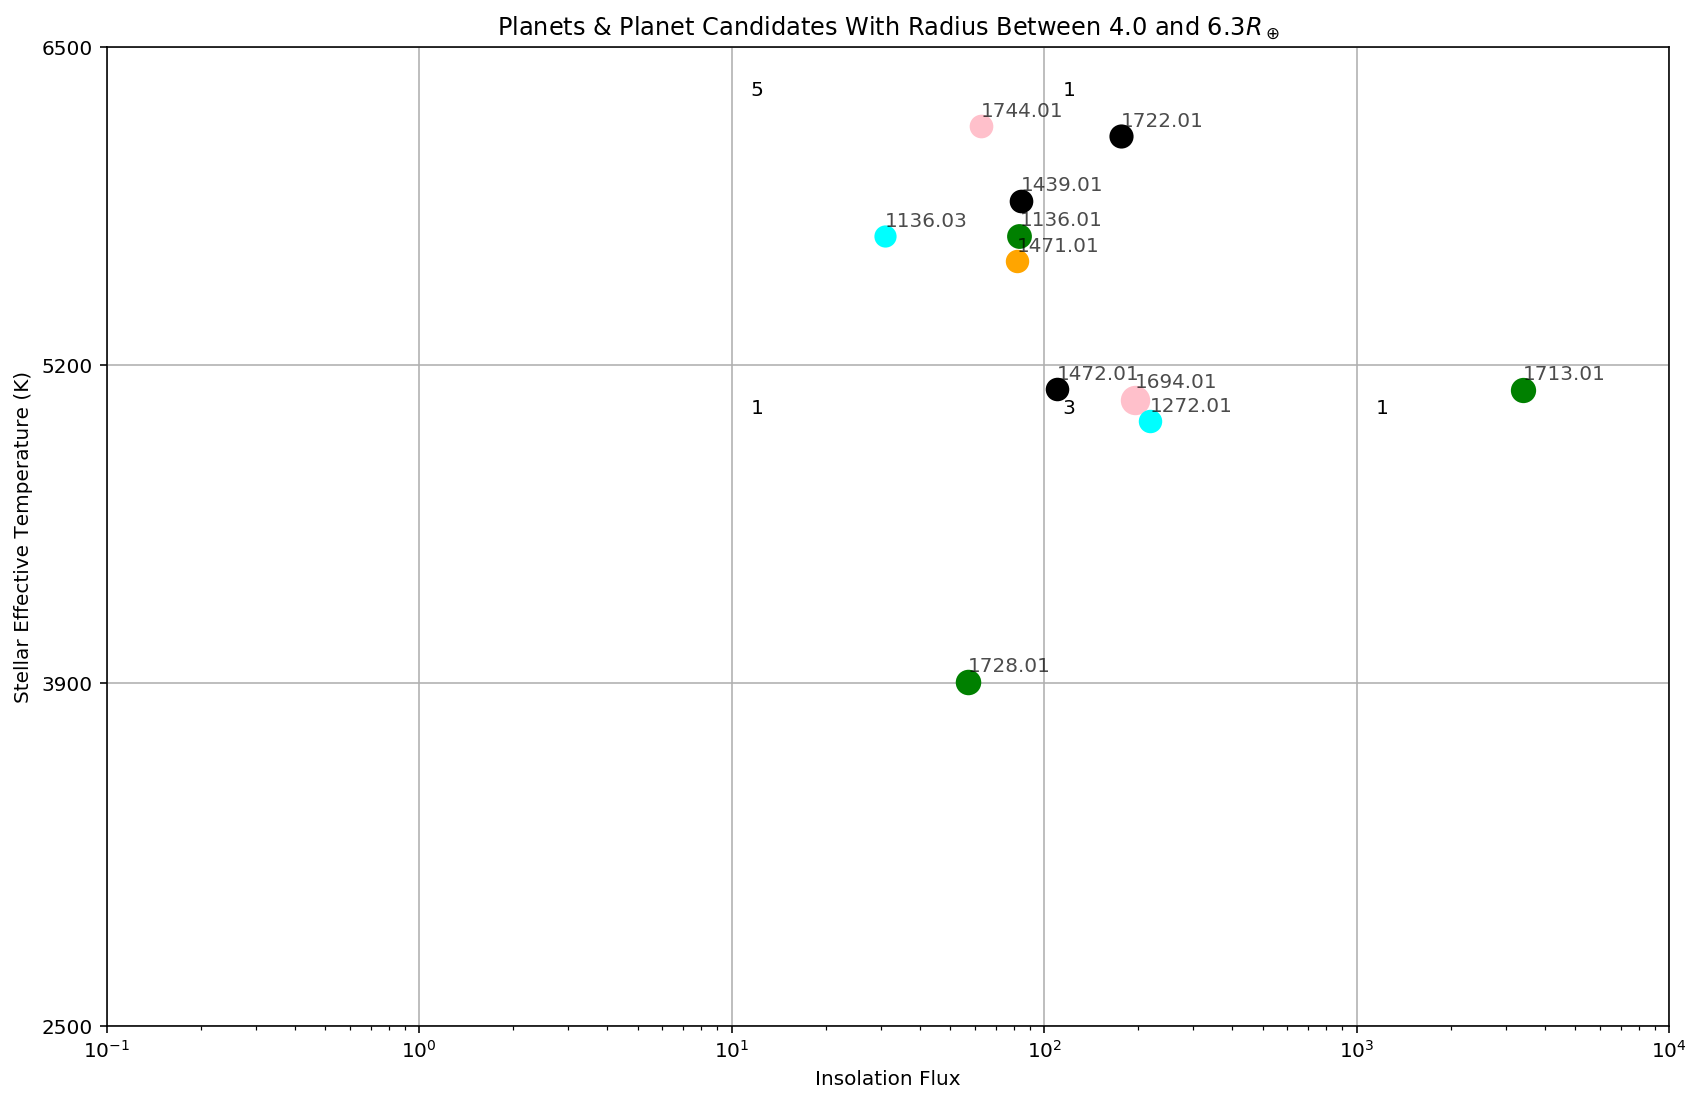

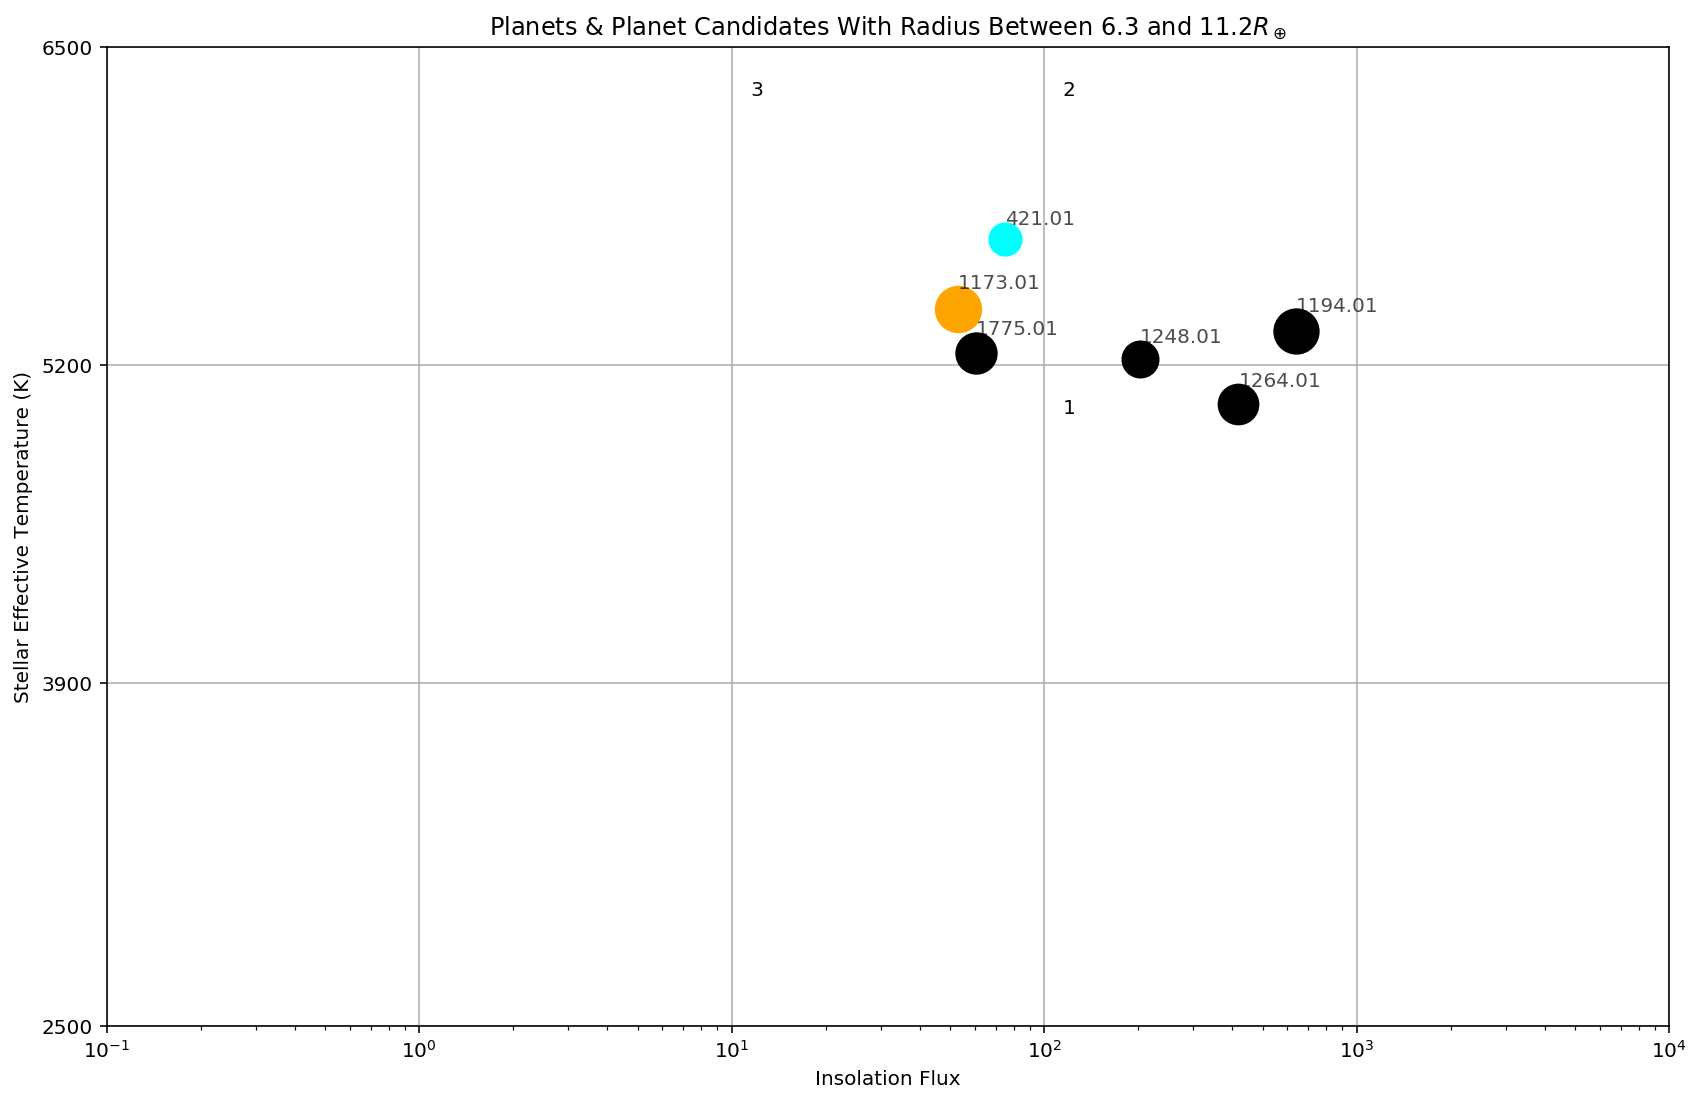

In [47]:
# Plotting the target list in bin-space
for i in np.arange(1,6):
    bin_plotter(target_list_bins_df.rename(columns={'X_priority':'priority'}),bins,i)

# ---------------------------------------------------------------------------------
# Now, let's say that a planet with a known mass is only a good atmospheric target if it's TSM value is at least half as large as the highest TSM of a TOI in its bin.
This will effectively increase the number of bins in parameter space that the TKS targets will fill out, because if a bin has a planet with a known mass, but that planet's TSM value is much worse than that of the best TSM for a TOI in that bin (worse by a factor of 2), then we shouldn't consider that bin "sampled" in our atmospheric candidates survey.

In [6]:
#create a vectorized type identifier to help distinguish if a Full TOI ID belongs to a TOI or a known planet
vtype = np.vectorize(type)

In [7]:
# The data/sc3_target_list_5ranked_mass_flag_X_priority_2020-04-10.csv gets rid of TOIs that are unranked 
# in their bins.
# 
# selected_toi_targets_df is a dataframe of TOIs that are ranked in the top 5 in their bins, and survied
# all of the merging and filtering that goes into the TKS selected_TOIs target pool.
selected_toi_targets_df = pd.read_csv('data/sc3_target_lists/sc3_target_list_2020-07-21.csv')
selected_toi_targets_df = selected_toi_targets_df.set_index(['radius_bin', 'insol_bin', 'st_Teff_bin']).sort_index()

# Put known planets with a mass and good TSM value in this dataframe
kp_good_TSM_mass_flag_1_df = pd.DataFrame()

# Iterate over each bin

for bin_key in X_df.index:
    
    # Placeholder values to start
    bin_max_ranked_toi_TSM = -1
    bin_max_kp_TSM  = -1
    bin_has_ranked_tois = False
    bin_has_kps  = False
    
    bin_df = X_df.loc[bin_key] # Need to use X_df, since it will have all of the relevant bins
    
    # Handles the case where there are no selected TOI targets in this bin
    try:
        bin_selected_toi_targets_df = selected_toi_targets_df.loc[bin_key]
    except:
        bin_selected_toi_targets_df = pd.DataFrame()
    
    # bin_tois_df = bin_df[vtype(bin_df['Full TOI ID'])==float] # Selected TOI targets in this bin
    bin_kp_df   = bin_df[vtype(bin_df['Full TOI ID'])==str]   # Known planets in this bin
    
    # If there are ranked TOIs in this bin that made it through to selected_TOIs
    if len(bin_selected_toi_targets_df) > 0:
        
        bin_has_ranked_tois = True
        bin_max_ranked_toi_TSM = np.max(bin_selected_toi_targets_df['TSM'])
        
    # Else, if there are known planets in this bin but no ranked TOIs that made it to selected_TOIs
    else:
        
        # Check if there are known planets in this bin
        if len(bin_kp_df) > 0:
            bin_has_kps = True
            bin_max_kp_TSM  = np.max(bin_kp_df['TSM'])
        
    # For each entry in this bin
    for index, row in X_df.loc[bin_key].iterrows(): 
        append = False
        
        # If the bin has ranked tois, then append this target to the list only if it has a known mass
        # and it's TSM is at least half as good as the highest TSM of a toi in the bin
        if bin_has_ranked_tois:
            append = (row['mass_flag'] == 1.) and (row['TSM']/bin_max_ranked_toi_TSM > 0.5)
        
        # Else, if the bin has ranked known planets, append this target to the list only if it has a known mass 
        # and it's TSM is at least half as good as the highest TSM of a known planet in the bin.
        # This gives us the targets in the bin with known masses that are above relative TSM cutoff.
        elif bin_has_kps:
            append = (row['mass_flag'] == 1.) and (row['TSM']/bin_max_kp_TSM > 0.5)
        
        # Else, don't append this target to the new list
        else:
            append = False
        
        # Handles some things to do with indexing
        if append:
            row['radius_bin'] = int(row.name[0])
            row['insol_bin']  = int(row.name[1])
            row['st_Teff_bin'] = int(row.name[2])
            kp_good_TSM_mass_flag_1_df = kp_good_TSM_mass_flag_1_df.append(row)

kp_good_TSM_mass_flag_1_df = kp_good_TSM_mass_flag_1_df.reset_index(drop=True)
kp_good_TSM_mass_flag_1_df = kp_good_TSM_mass_flag_1_df.set_index(['radius_bin', 'insol_bin', 'st_Teff_bin'])
kp_good_TSM_mass_flag_1_df = kp_good_TSM_mass_flag_1_df.drop_duplicates('Full TOI ID')

In [8]:
len(kp_good_TSM_mass_flag_1_df)

65

In [9]:
# Keep this line commented out unless you need to overwrite this file for some reason
# kp_good_TSM_mass_flag_1_df.to_csv('data/known_planets/kps_w_good_TSM_in_bin_2020-07-21.csv')

In [11]:
# Concatenate the dataframes that have the known planets with masses and a good TSM value and the TOIs 
# that are ranked priority 5 or higher in their bin and made it into selected_TOIs
tois_and_kp_good_TSM_mass_flag_1_df = pd.concat((selected_toi_targets_df, kp_good_TSM_mass_flag_1_df), sort=False)

In [12]:
# Use this line to print out a bin e.g. bin 2,2,1
tois_and_kp_good_TSM_mass_flag_1_df.sort_values('TSM', ascending=False).sort_index().loc[2,2,1]

Source Pipeline Full TOI ID  \
radius_bin insol_bin st_Teff_bin                               
2.0        2.0       1.0                    spoc     1468.01   
                     1.0                    spoc     1801.01   
                     1.0                    spoc     1802.01   

                                  Planet Radius Value  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                                              
2.0        2.0       1.0                     2.333273             15.531925   
                     1.0                     2.170286             21.284406   
                     1.0                     2.506646             16.796111   

                                  Effective Temperature Value  \
radius_bin insol_bin st_Teff_bin                                
2.0        2.0       1.0                               3382.0   
                     1.0                               3815.0   
                     1.0                               3859.0   

                                  Effective Stellar Flux Value  \
radius_bin insol_bin st_Teff_bin                                 
2.0        2.0       1.0                              2.140013   
                     1.0                              3.760847   
                     1.0                              5.920400   

                                  Planet Equilibrium Temperature (K) Value  \
radius_bin insol_bin st_Teff_bin                                             
2.0        2.0       1.0                                        308.477758   
                     1.0                                        355.174002   
                     1.0                                        397.839148   

                                  mass_flag   V mag     K_amp        TSM  \
radius_bin insol_bin st_Teff_bin                                           
2.0        2.0       1.0                0.0  12.500  3.097830  88.323028   
                     1.0                0.0  11.580  1.866617  58.377628   
                     1.0                0.0  12.763  2.482927  38.273626   

                                        t_HIRES         X  TSM_Vmag_priority  \
radius_bin insol_bin st_Teff_bin                                               
2.0        2.0       1.0           61601.990473  0.001434                NaN   
                     1.0           72710.924042  0.000803                NaN   
                     1.0          122174.895410  0.000313                NaN   

                                  X_priority      toi          tic       cps  \
radius_bin insol_bin st_Teff_bin                                               
2.0        2.0       1.0                 1.0  1468.01  243185500.0   T001468   
                     1.0                 3.0  1801.01  119584412.0  HIP57099   
                     1.0                 NaN  1802.01  138762614.0   T001802   

                                 disp vetting  ao_vet hires_prv apf_prv  \
radius_bin insol_bin st_Teff_bin                                          
2.0        2.0       1.0          VPC  passed     NaN       yes     NaN   
                     1.0           PC  passed  passed       NaN     NaN   
                     1.0           PC  passed  passed       NaN     NaN   

                                  vip_rank  
radius_bin insol_bin st_Teff_bin            
2.0        2.0       1.0               NaN  
                     1.0               NaN  
                     1.0               NaN

# Plot targets with known masses that are comparable atmospheric targets, as well as TOIs that are ranked at least priority 5 or better in their bin and made it into selected TOIs

**Plotting color key**:

    Green: Priority 1 target in its bin

    Yellow: Priority 2

    Orange: Priority 3

    Light pink: Priority 4

    Cyan: Priority 5

    Black: Unranked in its bin

    Magenta: A known planet with a mass measurement that is also a comparable atmospheric target in this bin

    Red: A known planet with a featureful transmission spectrum

    Gray: A known planet with a featureless transmission spectrum

/Users/josephmurphy/Documents/UCSC/research/2019-20/tks_target_shared/priority_tools.py:753: PerformanceWarning: indexing past lexsort depth may impact performance.
  size = len(binned_data.loc[rbin,f,t])


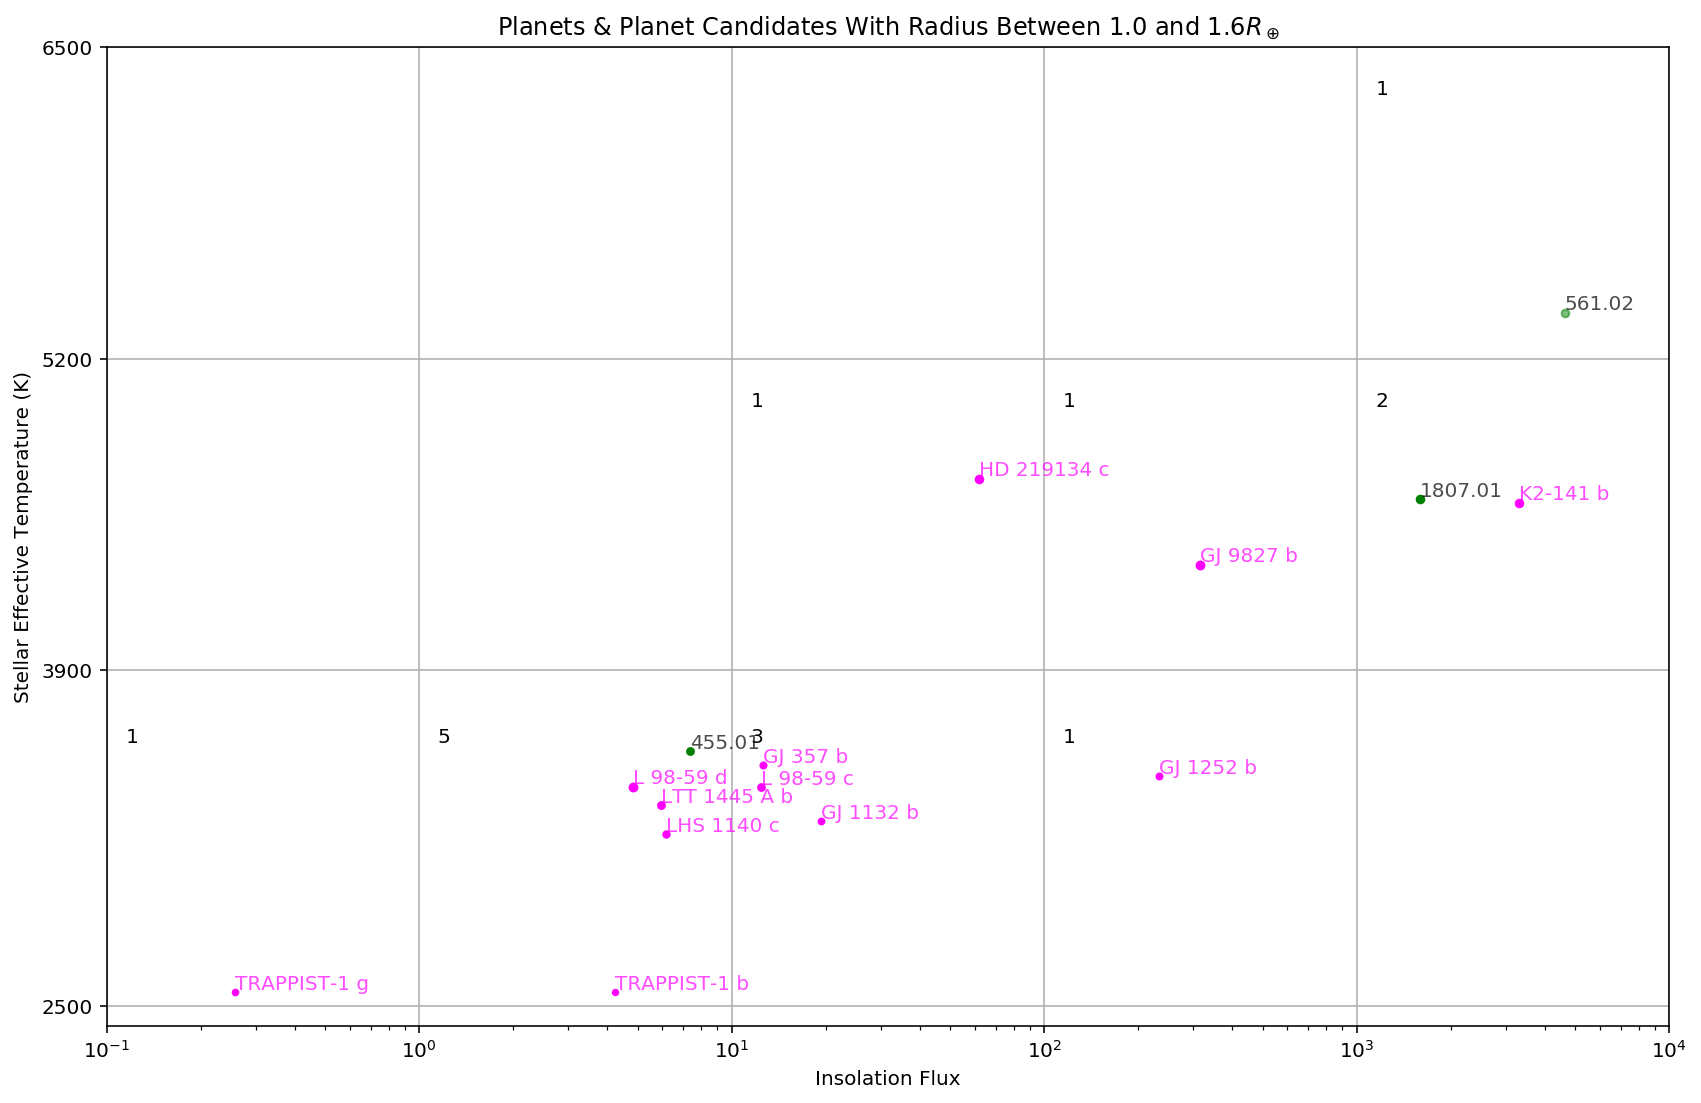

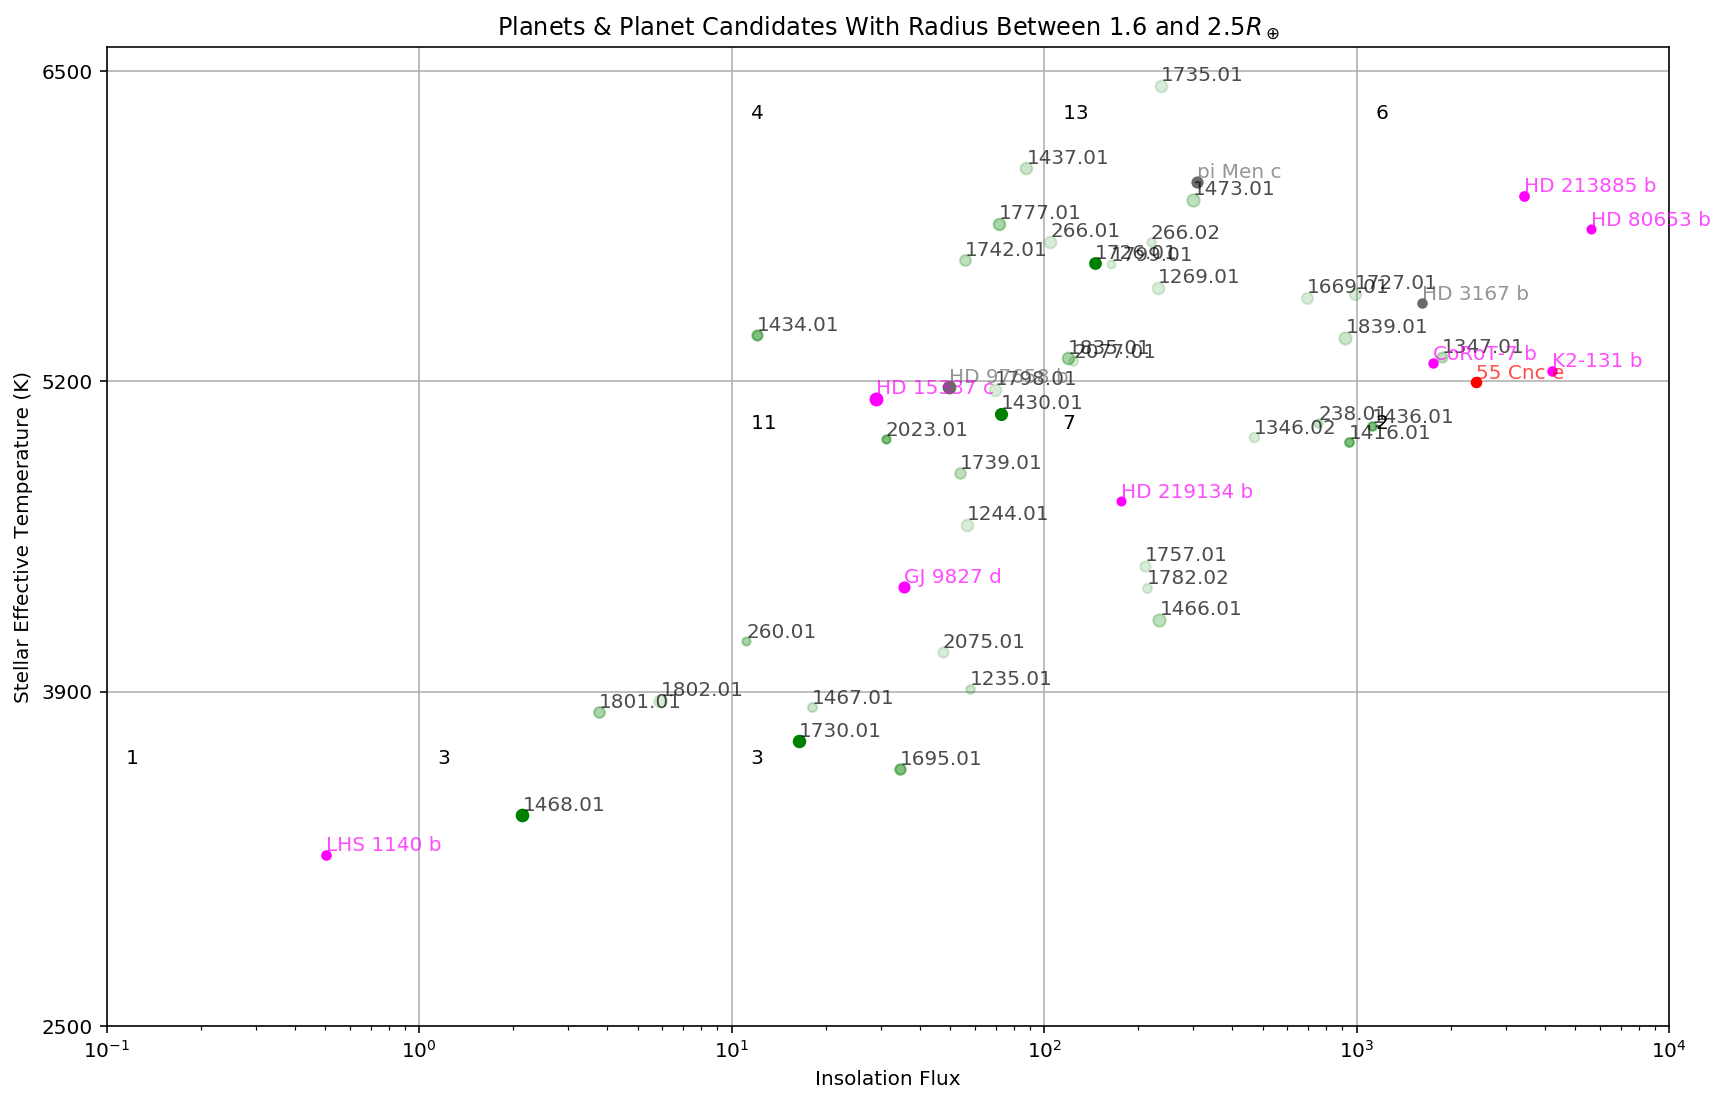

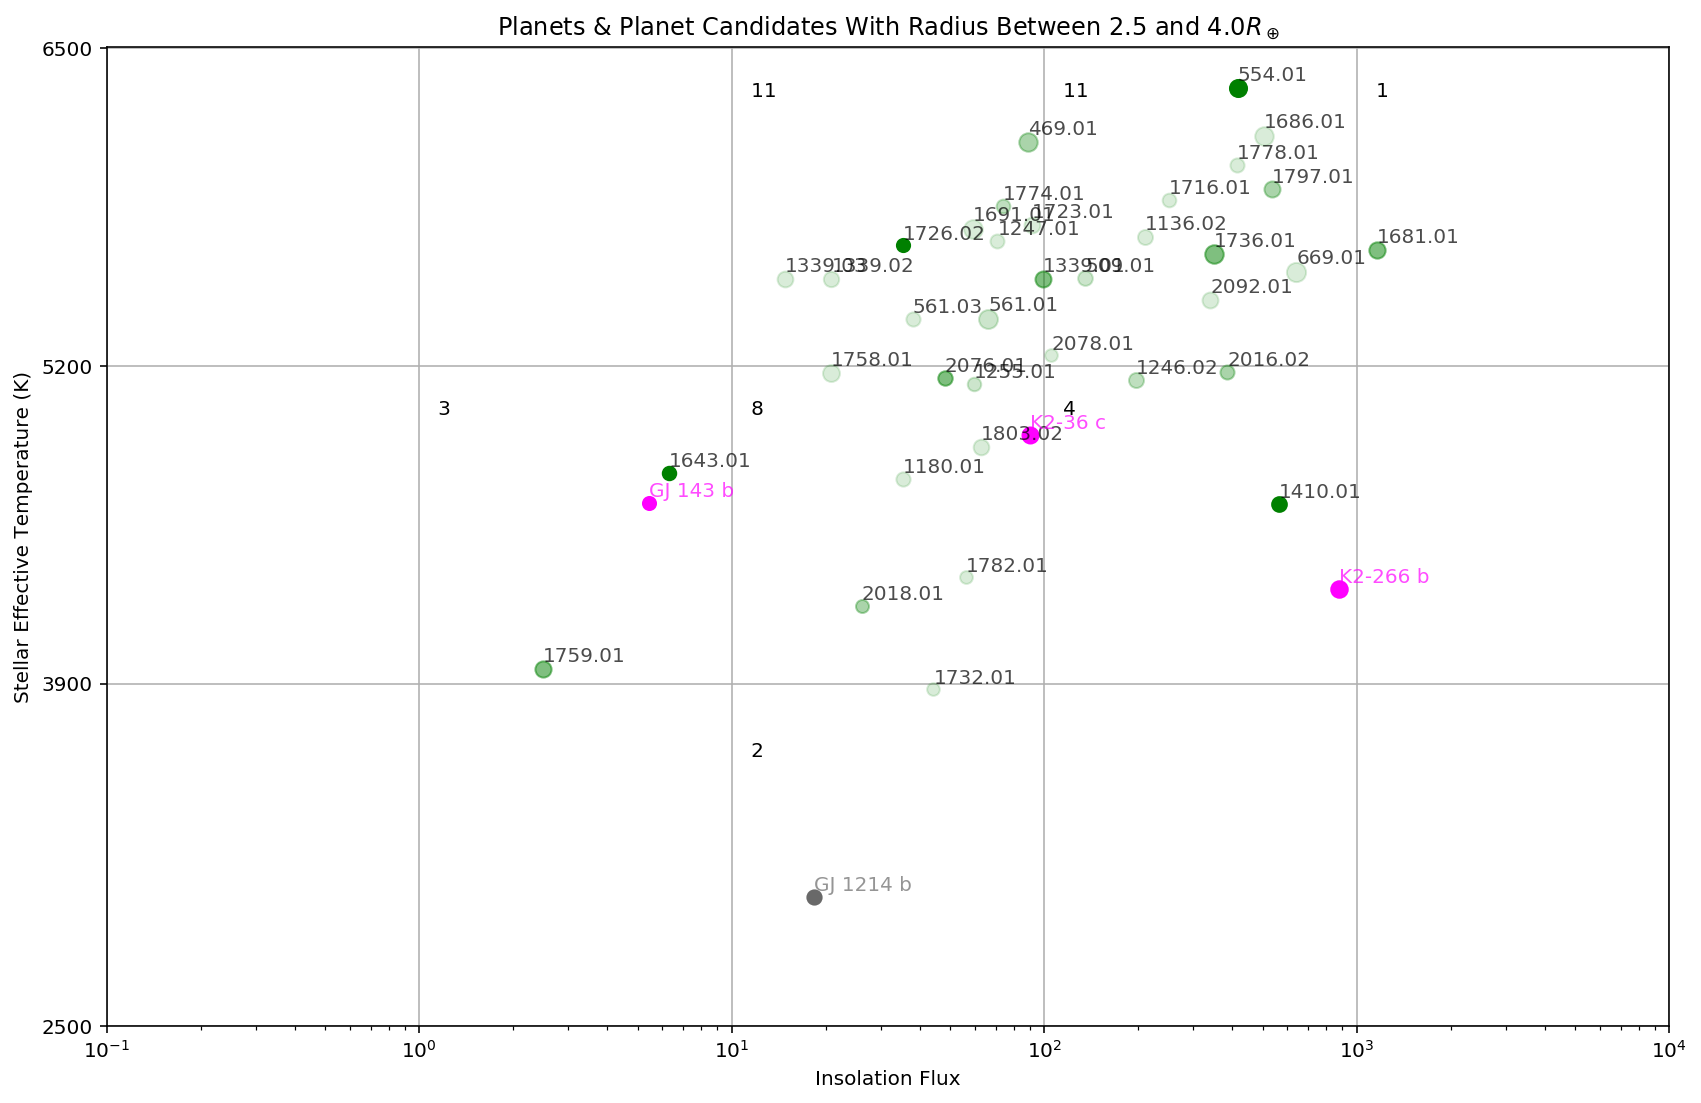

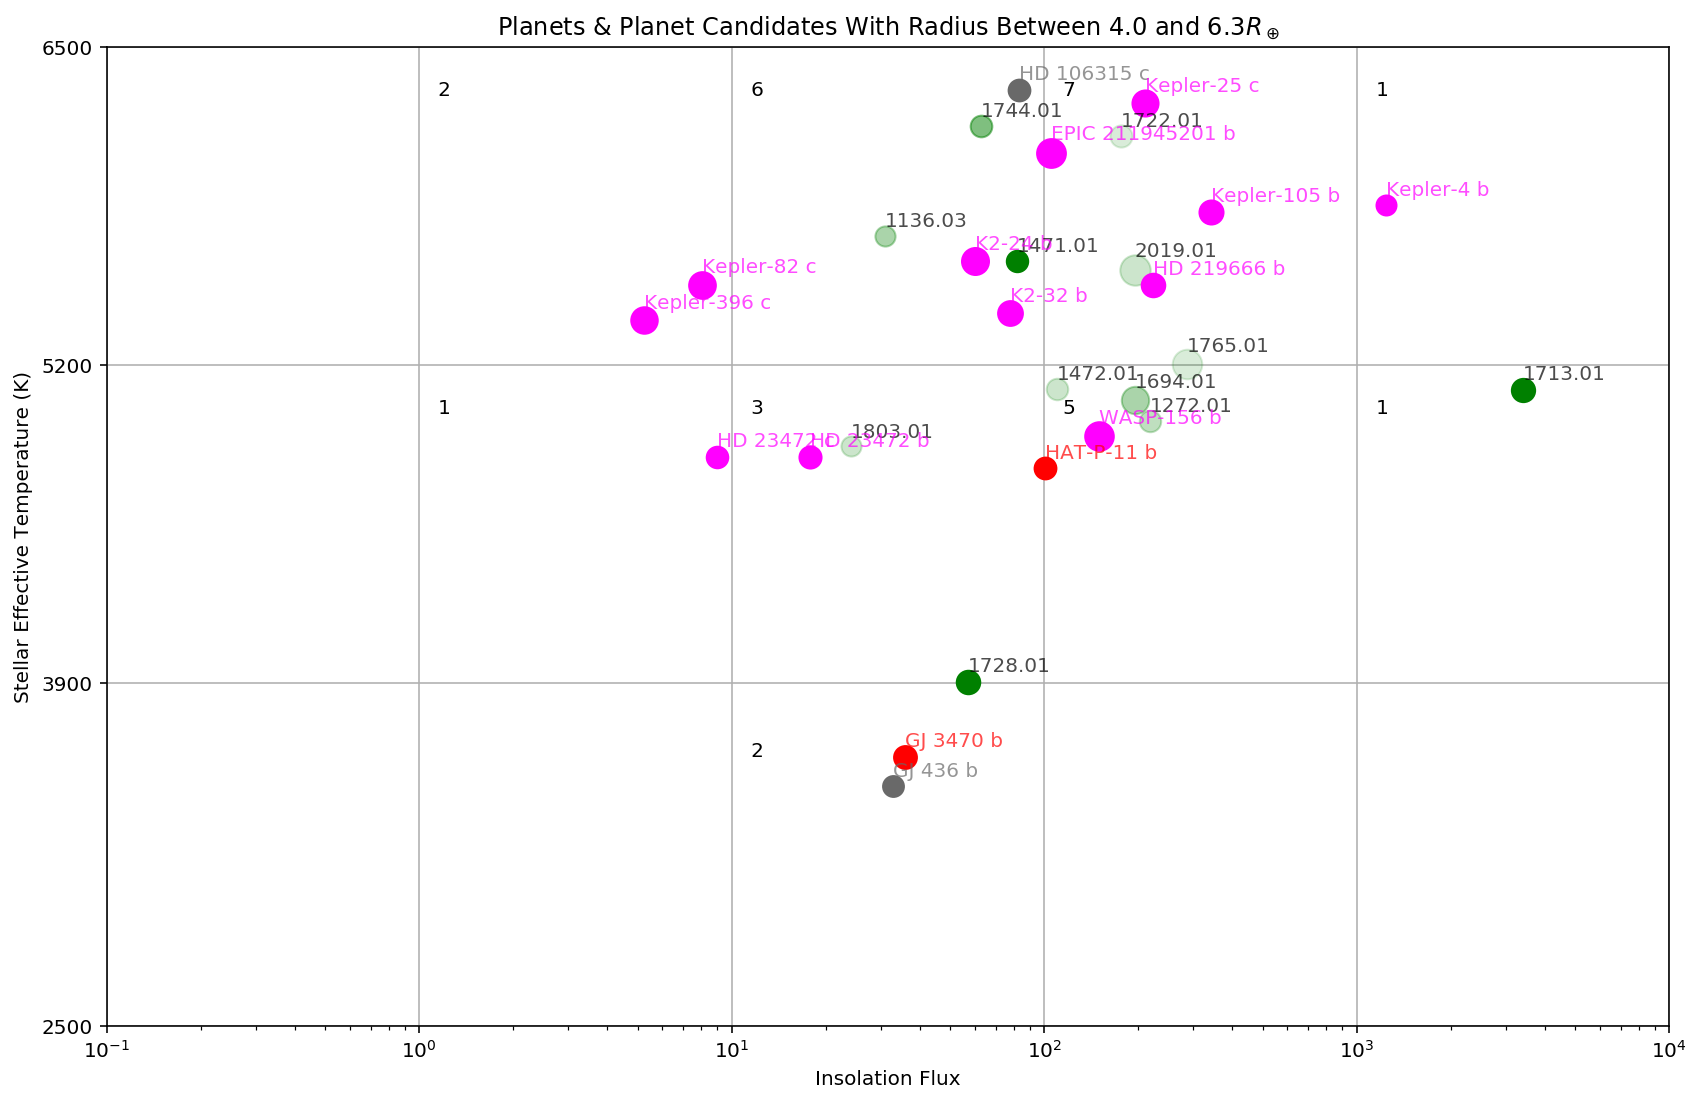

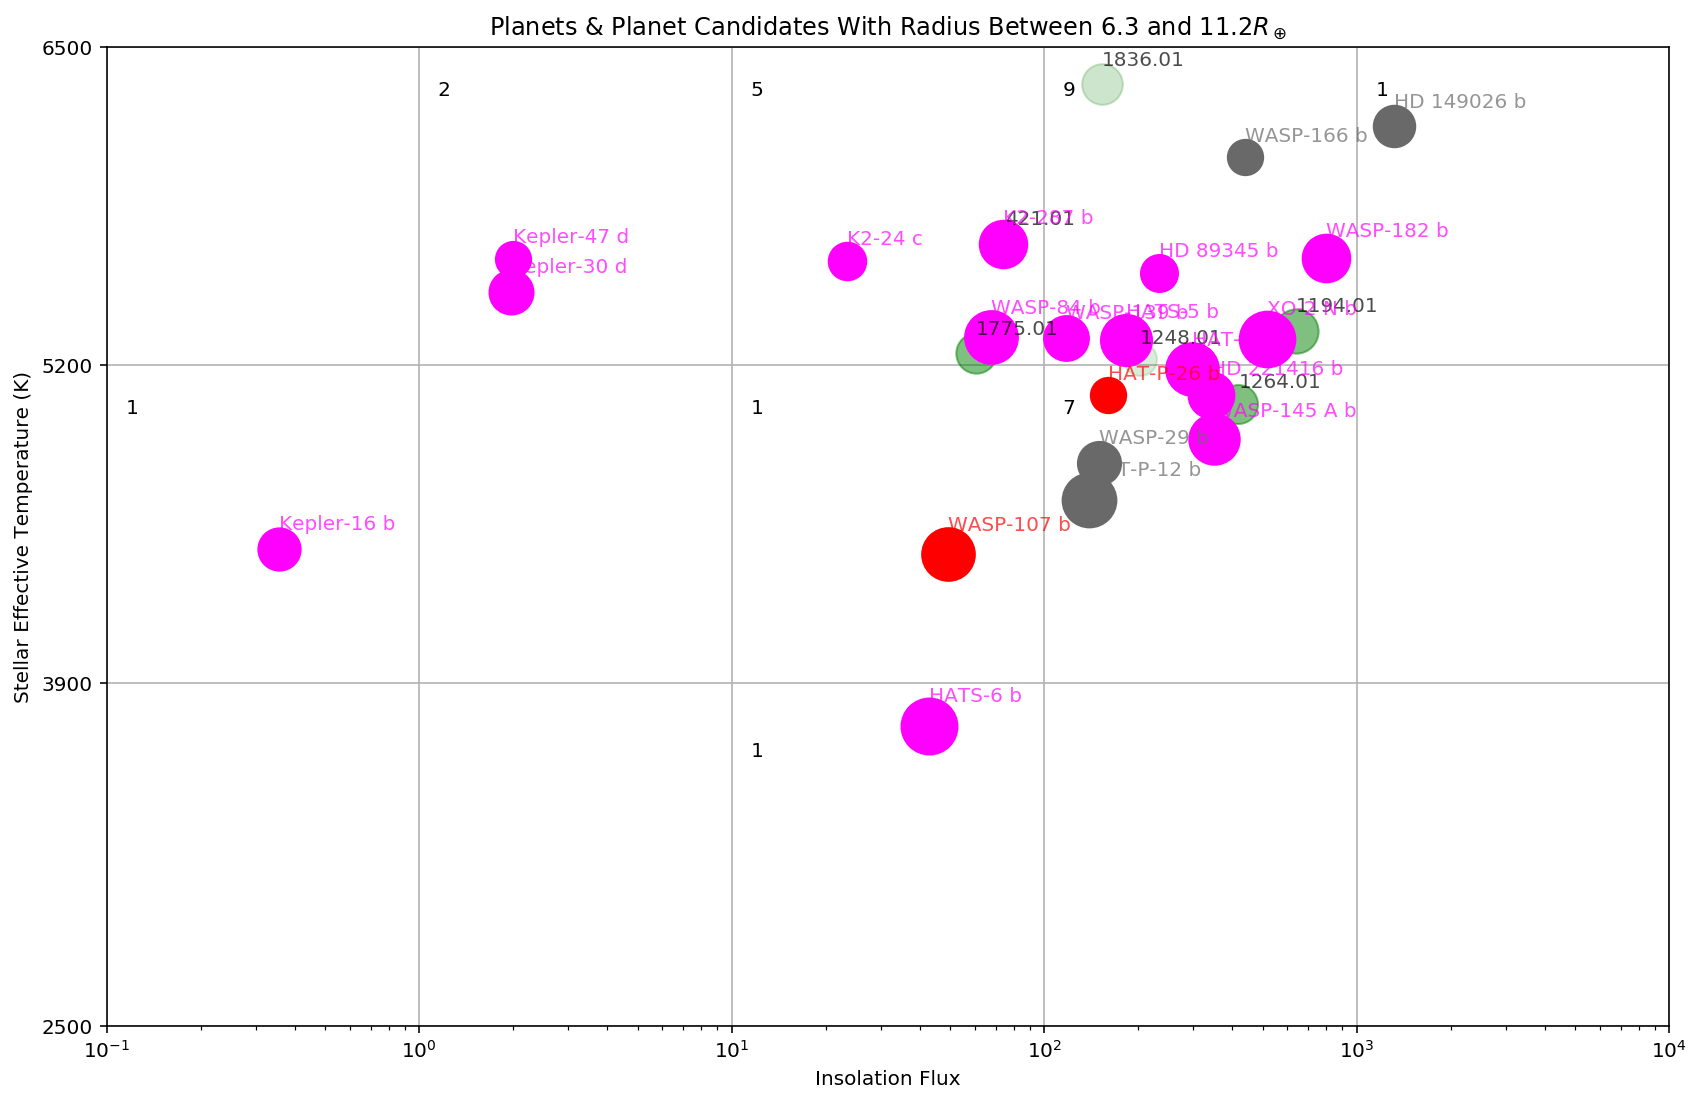

In [13]:
# Plot the combined data
for i in np.arange(1,6):
    fig, ax = bin_plotter(tois_and_kp_good_TSM_mass_flag_1_df.rename(columns={'X_priority':'priority'}),
                          bins,
                          i, 
                          use_alpha=True, 
                          show_fig=True) # Set show_fig to False if you want to save figure and uncomment line below
    # plt.savefig(f'binning_plot_rad_bin_{i}.pdf') # Uncomment line if you want to save figure and set show_fig=False

In [14]:
len(tois_and_kp_good_TSM_mass_flag_1_df.index.unique())

41

There are 41 unique bins that either have a planet with a known mass and a comparable TSM value for that bin, or a TOI that is ranked in the top 5 in its bin.

In [15]:
len(tois_and_kp_good_TSM_mass_flag_1_df[tois_and_kp_good_TSM_mass_flag_1_df['mass_flag'] == 1.].index.unique())

33

33 of those bins have at least one known planet with a mass measurement

In [16]:
# What are the TOIs in those bins? Plug in the bin here:
tois_and_kp_good_TSM_mass_flag_1_df.loc[(3,3,3)].sort_values('TSM', ascending=False)

/Users/josephmurphy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  


Source Pipeline Full TOI ID  \
radius_bin insol_bin st_Teff_bin                               
3.0        3.0       3.0                    spoc     1726.02   
                     3.0                    spoc     1339.01   
                     3.0                    spoc      469.01   
                     3.0                    spoc      561.01   
                     3.0                    spoc     1774.01   
                     3.0                    spoc     1339.02   
                     3.0                    spoc     1339.03   
                     3.0                    spoc     1247.01   
                     3.0                    spoc     1691.01   
                     3.0                    spoc     1723.01   
                     3.0                    spoc      561.03   

                                  Planet Radius Value  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                                              
3.0        3.0       3.0                     2.635970             20.545913   
                     3.0                     3.200173              8.880406   
                     3.0                     3.685246             13.632935   
                     3.0                     3.772776             10.781327   
                     3.0                     2.739662             16.710042   
                     3.0                     3.067978             28.579356   
                     3.0                     3.160000             38.350000   
                     3.0                     2.800653             15.923849   
                     3.0                     3.746702             16.731638   
                     3.0                     3.156970             13.716057   
                     3.0                     2.842121             16.371650   

                                  Effective Temperature Value  \
radius_bin insol_bin st_Teff_bin                                
3.0        3.0       3.0                              5694.11   
                     3.0                              5555.70   
                     3.0                              6114.00   
                     3.0                              5391.00   
                     3.0                              5853.70   
                     3.0                              5555.70   
                     3.0                              5555.70   
                     3.0                              5711.85   
                     3.0                              5759.00   
                     3.0                              5777.00   
                     3.0                              5391.00   

                                  Effective Stellar Flux Value  \
radius_bin insol_bin st_Teff_bin                                 
3.0        3.0       3.0                             35.353393   
                     3.0                             99.072187   
                     3.0                             89.071512   
                     3.0                             66.330454   
                     3.0                             73.760947   
                     3.0                             20.850938   
                     3.0                             14.800000   
                     3.0                             70.932692   
                     3.0                             59.350052   
                     3.0                             91.580168   
                     3.0                             38.003128   

                                  Planet Equilibrium Temperature (K) Value  \
radius_bin insol_bin st_Teff_bin                                             
3.0        3.0       3.0                                        621.909976   
                     3.0                                        804.651244   
                     3.0                                        783.527882   
                     3.0                                        727.860233   